In [6]:
"""
This script plots the mean profile of certain combinations of symbols.
"""
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

import scipy as sp
import scipy.signal

import preprocessing as pp

# plt.rcParams['figure.figsize'] = [3*6.9,3*2.3]  # use for notebook viewing
plt.rcParams['figure.figsize'] = [8, 5]  # TODO use for paper

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['lines.marker']  #None
plt.rcParams['lines.markersize'] = 2  #6.0
plt.rcParams['lines.linewidth'] = 1  # 1.5
plt.rcParams['figure.constrained_layout.use'] = True

In [7]:
def find_sequence(data, key):
    """
    This method returns all the starting positions where the key sequence can be found.
    """
    string_data = "".join(data)
    result = [m.start() for m in re.finditer('(?=' + key + ')', string_data)]
    print(f"found key {key} {len(result)} times in the data")

    return np.array(result)


def mean_and_std(data):
    """
    This method returns the mean values and the standard deviation of the input data.
    """
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)

    return mean, std


def select_nth_and_std(data, n=0):
    """
    This method returns the mean values and the standard deviation of the input data.
    """
    first = data[n]
    std = np.std(data, axis=0)

    return first, std


def plot_opacity(data, labels, clock, key, pos_target=0):
    plt.title(key)
    matching_data = data[find_sequence(labels, key) + pos_target]

    mean, std = mean_and_std(matching_data)

    for i, elem in enumerate(matching_data):
        plt.plot(elem, 'b', alpha=0.005)

    plt.plot(mean, 'r')
    plt.show()


def plot_opacity_histogram(data, labels, clock, key, pos_target=0):
    plt.title(key)
    matching_data = np.array(data[find_sequence(labels, key) + pos_target])
    plt.hist(matching_data[700, :], bins=20)
    plt.show()


def find_drift(clock):
    show_result_one(mean_and_std(clock), "clock")


def plot_spectrogram(data):
    f, t, Sxx = sp.signal.spectrogram(data[:1_000_00], data["sample_freq"], nperseg=10)
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()


def show_result_one(result, key):
    """
    This method plots the result with one data point.
    """
    mean, std = result
    upper_bound = mean + std
    lower_bound = mean - std
    plt.title(key)
    plt.plot(mean)
    plt.plot(upper_bound, 'r')
    plt.plot(lower_bound, 'r')
    plt.show()


def show_result_four_clock_ax(ax, result, clock,
                              label_key1, label_key2, label_key3, label_key4,
                              technical_details,
                              plot_clk=False,
                              alpha=1,
                              add_to_legend=True,
                              add_symbol_axis=True,
                              do_x_axis=True,
                              ):
    """
    Plots four traces to given axes.
    """
    mean1, std1 = result[0]
    mean2, std2 = result[1]
    mean3, std3 = result[2]
    mean4, std4 = result[3]

    ax.set_xlim([100, 800])
    ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])

    ax.plot(mean1 * 1000, label=label_key1, color="#0a4493ff", alpha=alpha, )
    ax.plot(mean2 * 1000, label=label_key2, color="#803310ff", alpha=alpha, )
    ax.plot(mean3 * 1000, label=label_key3, color="#107045ff", alpha=alpha, )
    ax.plot(mean4 * 1000, label=label_key4, color="#7a7c0bff", alpha=alpha, )

    if plot_clk:
        ax.plot(clock * 1000, label="clock", color="#d51b64ff")

    ax.grid(which='major', color='#CCCCCC')
    #ax.grid(which='minor', color='#CCCCCC')

    ax.xaxis.set_major_locator(MultipleLocator(100))
    #ax.yaxis.set_major_locator(MultipleLocator(20))

    #ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    #ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    axesthickness = 1

    # increase tick width
    ax.tick_params(width=axesthickness)
    font = {'family': 'Arial',
            'weight': 'normal',
            'size': 10}
    ax.set_ylabel("Probe Signal (mV)")

    if add_symbol_axis:
        ax2 = ax.twiny()
        ax2.set_xlabel("Symbol index")

        ax2.set_xticks(ax.get_xticks())
        ax2.set_xbound(ax.get_xbound())
        ax2.set_xticklabels([int(x / 100 + 1 - 2) for x in ax.get_xticks()])

    ax.set_xlim([100, 800])
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))

    ax.xaxis.set_tick_params(which='major', size=3, width=axesthickness, direction='in', top='on')
    ax.xaxis.set_tick_params(which='minor', size=2, width=axesthickness, direction='in', top='on')
    if do_x_axis:
        ax.set_xlabel("Sample index")
        ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])
    else:
        ax.set_xticklabels([])

    ax.yaxis.set_tick_params(which='major', size=3, width=axesthickness, direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=2, width=axesthickness, direction='in', right='on')

    if add_symbol_axis:
        ax2.xaxis.set_tick_params(which='major', size=3, width=axesthickness, direction='in', top='on')
        ax2.xaxis.set_tick_params(which='minor', size=2, width=axesthickness, direction='in', top='on')

    # change all spines
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(axesthickness)

    if add_symbol_axis:
        ax2.spines['top'].set_linewidth(axesthickness)

        ax2.xaxis.set_ticks_position('bottom')  # set the position of the second x-axis to bottom
        ax2.xaxis.set_label_position('bottom')  # set the position of the second x-axis to bottom
        ax2.spines['bottom'].set_position(('outward', 36))

    plt.rc('font', **font)

    if add_to_legend:
        leg = ax.legend(bbox_to_anchor=(1, 1), loc=1, frameon=True)
        for lh in leg.legendHandles:
            lh.set_alpha(1)


def accumulate_plots(ax, data, labels, clock,
                     key1, key2, key3, key4,
                     technical_details, pos_target=0,
                     plot_clk=False, do_average=False,
                     select_occurance=0,
                     alpha=1.,
                     add_to_legend=True,
                     add_symbol_axis=True,
                     do_x_axis=True,
                     ):
    if do_average and select_occurance != 0:
        raise ValueError(
            "`select_occurance` != 0 only makes sense when `do_average` is false. Nothing to select when everything is averaged.")

    result = []

    extract_data = mean_and_std if do_average else (lambda data: select_nth_and_std(data, n=select_occurance))

    matching_data = data[find_sequence(labels, key1) + pos_target]
    result.append(extract_data(matching_data))

    matching_data = data[find_sequence(labels, key2) + pos_target]
    result.append(extract_data(matching_data))

    matching_data = data[find_sequence(labels, key3) + pos_target]
    result.append(extract_data(matching_data))

    matching_data = data[find_sequence(labels, key4) + pos_target]
    result.append(extract_data(matching_data))

    show_result_four_clock_ax(ax, result, clock, key1, key2, key3, key4, technical_details,
                              plot_clk=plot_clk, alpha=alpha,
                              add_to_legend=add_to_legend, add_symbol_axis=add_symbol_axis, do_x_axis=do_x_axis, )

In [8]:
debug = False  # Set this to True if you want to see the header detection result during the pre processing

data_directory = os.path.join("..", "DownloadedData", "Rev1Distance", "0cm")

# Technical details of your experimental setup
technical_details = {
    "header_length": 1,  # Number of symbols used to identify the header
    "clock_freq": int(100e6),  # Clock frequency (Hz) of the sender electronics
    "sample_freq": int(1e10),  # Sample frequency (Hz) used by oscilloscope
    "signal_length": 2_000_002,  # Total number of data points of one measurement
    "steps_to_left": 2,  # start for the cut position in symbols to the left from the header position
    "steps_to_right": 7,  # end for the cut position in symbols to the right from the header position
    "do_normalize_data": False,  # Use if data should be normalized to have zero mean and std 1
}

offset_header_rev1 = -200
offset_header_rev2 = 200
if "rev1" in data_directory.lower():
    offset_header = offset_header_rev1
elif "rev2" in data_directory.lower():
    offset_header = offset_header_rev2
else:
    raise NotImplementedError("Specify which offset should be used!")

In [9]:
def show_npy_contents(ax,
                      key1, key2, key3, key4,
                      data_file_prefix="train_0",
                      plot_clk=False,
                      do_average=False,
                      select_occurance=0,
                      alpha=1.,
                      add_to_legend=True,
                      add_symbol_axis=True,
                      do_x_axis=True,
                      ):
    """
    compare average signals corresponding to given symbol sequences
    """
    if do_average and select_occurance != 0:
        raise ValueError(
            "`select_occurance` != 0 only makes sense when `do_average` is false. Nothing to select when everything is averaged.")

    prefix = "training" if data_file_prefix[:5] == "train" else "test"

    training_data, training_labels, train_start = pp.load_data_synchronized(
        folder_path=data_directory,
        file_path=os.path.join(data_directory, f"{data_file_prefix}_data_numpy.npy"),
        file_path_synch=os.path.join(data_directory, f"{data_file_prefix}_synch_debug_signal_numpy.npy"),
        prefix=prefix,
        clock_freq=technical_details["clock_freq"],
        sample_freq=technical_details["sample_freq"],
        signal_length=technical_details["signal_length"],
        offset_header=offset_header,
        debug=debug)

    training_data = training_data - np.average(training_data)

    processed_training_data, processed_training_labels = pp.cut_data_in_pieces(training_data, training_labels,
                                                                               train_start,
                                                                               header_length=technical_details[
                                                                                   'header_length'],
                                                                               technical_details=technical_details)

    clock = pp.cut_clock_in_pieces(training_data, technical_details)
    # find_drift(clock)
    # plot_mean_std(processed_training_data, processed_training_labels, clock[0], "VP", pos_target=0)
    # plot_opacity(processed_training_data, processed_training_labels, clock[0], "VH", pos_target=1)
    # plot_opacity_histogram(processed_training_data, processed_training_labels, clock[0], "MP", pos_target=1)
    accumulate_plots(ax, processed_training_data, processed_training_labels, clock[0],
                     key1, key2, key3, key4,
                     technical_details, plot_clk=plot_clk, pos_target=0,
                     do_average=do_average, select_occurance=select_occurance,
                     alpha=alpha,
                     add_to_legend=add_to_legend, add_symbol_axis=add_symbol_axis, do_x_axis=do_x_axis)

Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])
/tmp/ipykernel_308890/215379424.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


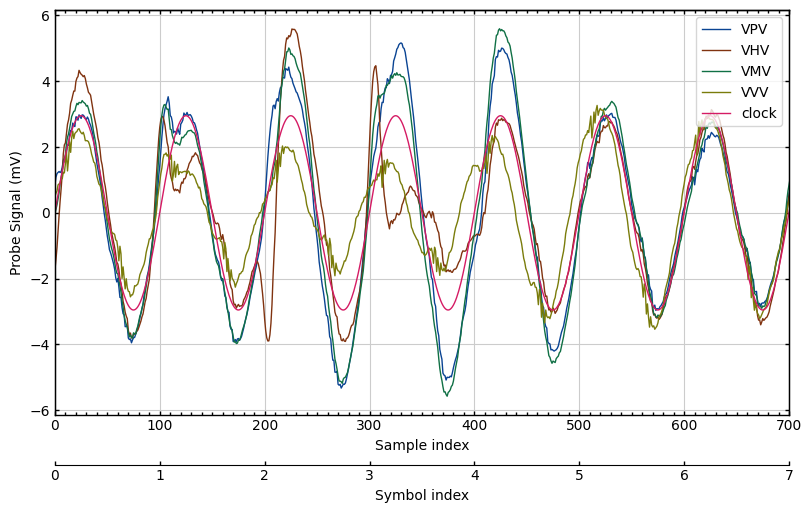

In [10]:
fig, ax = plt.subplots(1)

symbols = ["VPV", "VHV", "VMV", "VVV"]

show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], data_file_prefix="train_0", plot_clk=True,
                  do_average=True)
# show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], data_file_prefix="train_1", plot_clk=True, do_average=True)
# show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], data_file_prefix="train_2", plot_clk=True, do_average=True)
# show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], data_file_prefix="train_3", plot_clk=True, do_average=True)

plt.savefig("tmp_averaged.pdf")

### combined plot of non-averaged and averaged traces (see next section for cleaner example)

Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])
/tmp/ipykernel_308890/215379424.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


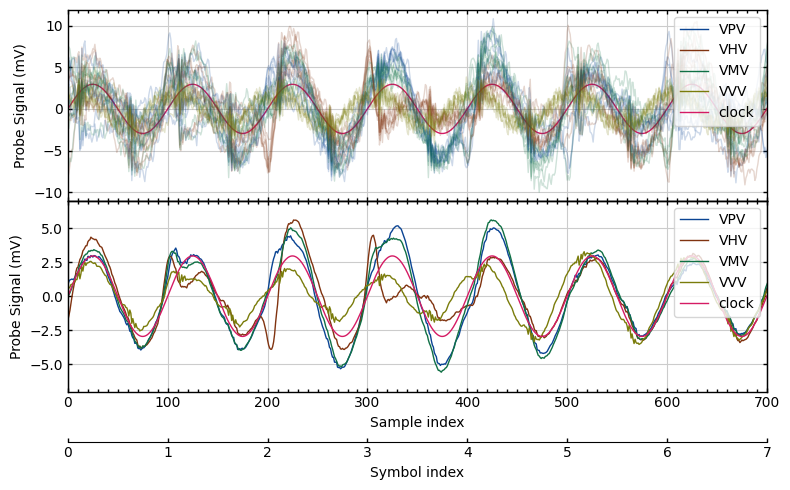

In [11]:
fig, ax = plt.subplots(2, 1, constrained_layout=False)

avg_ax = ax[0]

symbols = ["VPV", "VHV", "VMV", "VVV"]

# plot upper plot (non-averaged traces)
kwargs_first = {'data_file_prefix': "train_0", 'do_average': False, 'alpha': 0.2, 'add_symbol_axis': False,
                'do_x_axis': False}

show_npy_contents(avg_ax, symbols[0], symbols[1], symbols[2], symbols[3], select_occurance=0, add_to_legend=True,
                  plot_clk=True, **kwargs_first)

kwargs_rest = {'data_file_prefix': "train_0", 'do_average': False, 'alpha': 0.2,
               'add_symbol_axis': False, 'plot_clk': False, 'add_to_legend': False, 'do_x_axis': False}

show_npy_contents(avg_ax, symbols[0], symbols[1], symbols[2], symbols[3], select_occurance=1, **kwargs_rest)
show_npy_contents(avg_ax, symbols[0], symbols[1], symbols[2], symbols[3], select_occurance=2, **kwargs_rest)
show_npy_contents(avg_ax, symbols[0], symbols[1], symbols[2], symbols[3], select_occurance=3, **kwargs_rest)
show_npy_contents(avg_ax, symbols[0], symbols[1], symbols[2], symbols[3], select_occurance=4, **kwargs_rest)
show_npy_contents(avg_ax, symbols[0], symbols[1], symbols[2], symbols[3], select_occurance=5, **kwargs_rest)
show_npy_contents(avg_ax, symbols[0], symbols[1], symbols[2], symbols[3], select_occurance=6, **kwargs_rest)

# plot lower plot (averaged traces)
show_npy_contents(ax[1], symbols[0], symbols[1], symbols[2], symbols[3], data_file_prefix="train_0",
                  plot_clk=True, do_average=True, )

plt.tight_layout()
plt.subplots_adjust(wspace=None, hspace=0)
ax[1].set_ylim(-7, 7)

plt.savefig("tmp_combined_averaged_nonaveraged.pdf", dpi=400)

## Not averaged, different occurances of pattern in single dataset

Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])
/tmp/ipykernel_308890/215379424.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])
/tmp/ipykernel_308890/215379424.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])
/tmp/ipykernel_308890/215379424.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])
/tmp/ipykernel_308890/215379424.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])
/tmp/ipykernel_308890/215379424.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])
/tmp/ipykernel_308890/215379424.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])
/tmp/ipykernel_308890/215379424.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


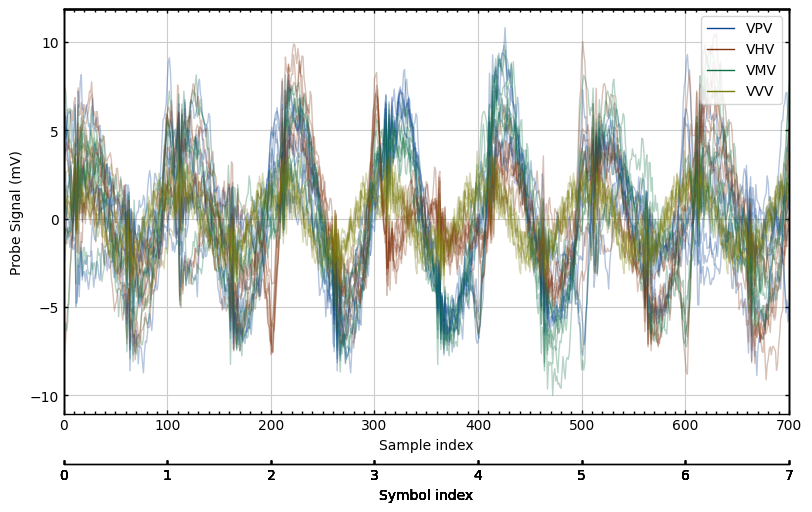

In [12]:
fig, ax = plt.subplots(1)

# symbols = ["MHVPVHM", "MHVHVHM", "MHVMVHM", "MHVVVHM"]
symbols = ["VPV", "VHV", "VMV", "VVV"]

kwargs = {'data_file_prefix': "train_0", "plot_clk": False, 'do_average': False, 'alpha': 0.3}

show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], select_occurance=0, add_to_legend=True, **kwargs)
show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], select_occurance=1, add_to_legend=False, **kwargs)
show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], select_occurance=2, add_to_legend=False, **kwargs)
show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], select_occurance=3, add_to_legend=False, **kwargs)
show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], select_occurance=4, add_to_legend=False, **kwargs)
show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], select_occurance=5, add_to_legend=False, **kwargs)
show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], select_occurance=6, add_to_legend=False, **kwargs)

# show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], data_file_prefix="train_1", plot_clk=True, do_average=False)
# show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], data_file_prefix="train_2", plot_clk=True, do_average=False)
# show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], data_file_prefix="train_3", plot_clk=True, do_average=False)
# show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], data_file_prefix="test_0", plot_clk=True, do_average=False)

plt.savefig("tmp_notaveraged.pdf")

## Not averaged, zeroth occurance of pattern across datasets

Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])
/tmp/ipykernel_308890/215379424.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])
/tmp/ipykernel_308890/215379424.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])
/tmp/ipykernel_308890/215379424.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])
/tmp/ipykernel_308890/215379424.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Cut data in pieces with these shapes: after header:(14091, 900), before header:(5884, 900)
prepared clock data with shape:(19990, 900)
found key VPV 350 times in the data
found key VHV 284 times in the data
found key VMV 334 times in the data
found key VVV 365 times in the data


/tmp/ipykernel_308890/215379424.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])
/tmp/ipykernel_308890/215379424.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x - 100) for x in ax.get_xticks()])


AssertionError: File ../DownloadedData/Rev1Distance/0cm/train_5_data_numpy.npy does not exist.

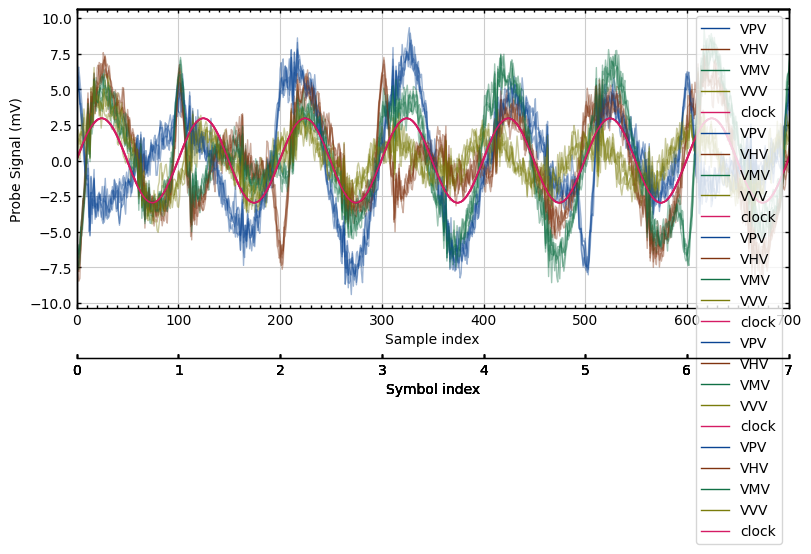

In [13]:
fig, ax = plt.subplots(1)

# symbols = ["MHVPVHM", "MHVHVHM", "MHVMVHM", "MHVVVHM"]
symbols = ["VPV", "VHV", "VMV", "VVV"]

show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], data_file_prefix="train_0", plot_clk=True,
                  do_average=False, select_occurance=0, alpha=0.4)
show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], data_file_prefix="train_1", plot_clk=True,
                  do_average=False, select_occurance=0, alpha=0.4)
show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], data_file_prefix="train_2", plot_clk=True,
                  do_average=False, select_occurance=0, alpha=0.4)
show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], data_file_prefix="train_3", plot_clk=True,
                  do_average=False, select_occurance=0, alpha=0.4)
show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], data_file_prefix="train_4", plot_clk=True,
                  do_average=False, select_occurance=0, alpha=0.4)
show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], data_file_prefix="train_5", plot_clk=True,
                  do_average=False, select_occurance=0, alpha=0.4)
show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], data_file_prefix="train_6", plot_clk=True,
                  do_average=False, select_occurance=0, alpha=0.4)
# show_npy_contents(ax, symbols[0], symbols[1], symbols[2], symbols[3], data_file_prefix="test_0", plot_clk=True, do_average=False)